In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML


In [34]:
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2018, 2019, 2020, 2021, 2022], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2023, 2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

Loading data for 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for 2015
skipping  2015
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2019/game_401127989.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2019/game_401127963.csv
Loading data for 2021
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2021/game_401326405.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2021/game_401326412.csv
Loading data for 2020
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/

In [50]:
import xgboost as xgb

class XGBoost:
    def __init__(self, **kwargs):
        self.model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='auc'
        )
    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X, y):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def score(self, X, y):
        return self.model.score(X, y)


from lightgbm import LGBMClassifier

class LightGBM:
    def __init__(self, **kwargs):
        params = dict(
            n_estimators=500,
            max_depth=-1,        # -1 = full depth
            num_leaves=63,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary",
            metric="binary_logloss"
        )
        params.update(kwargs)
        self.model = LGBMClassifier(**params)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def score(self, X, y):
        return self.model.score(X, y)


import catboost as cb

class CatBoost:
    def __init__(self, **kwargs):
        params = dict(
            iterations=300,
            depth=5,
            learning_rate=0.001,
            l2_leaf_reg=10,
            loss_function="Logloss",
            eval_metric="AUC",
            random_strength=1.0,
            bagging_temperature=1.0,
            verbose=True
        )
        params.update(kwargs)
        self.model = cb.CatBoostClassifier(**params)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [49]:
models = {}
def setup_models(training_data, test_data):
    for timestep in training_data:
        print(f"Processing timestep: {timestep}")
        X = training_data[timestep]
        y = np.array([row["label"] for row in X])
        X = np.array([row["rows"].reshape(-1) for row in X])
        y_test = np.array([row["label"] for row in test_data[timestep]])
        X_test = np.array([row["rows"].reshape(-1) for row in test_data[timestep]])
        # Evaluate model using the pipeline (preprocessing + logistic regression)
        model = CatBoost()
        model.fit(X, y)
         # Calculate training loss
        y_pred = model.predict_proba(X)[:, 1]  # Get probability predictions
        train_loss = -np.mean(y * np.log(y_pred + 1e-15) + (1-y) * np.log(1-y_pred + 1e-15))  # Binary cross entropy
        train_accuracy = model.score(X, y)

        y_test_pred = model.predict_proba(X_test)[:, 1]
        test_loss = -np.mean(y_test * np.log(y_test_pred + 1e-15) + (1-y_test) * np.log(1-y_test_pred + 1e-15))  # Binary cross entropy 
        test_accuracy = model.score(X_test, y_test)

        print(f"Timestep {timestep:.2%}: Training Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")
        models[timestep] = model


# setup_models(training_data, test_data)


In [ ]:
def setup_single_model(training_data, test_data):
    # Flatten all training data into single arrays
    X_train = []
    y_train = []
    timesteps_train = []
    for timestep in training_data:
        for row in training_data[timestep]:
            X_train.append(row["rows"].reshape(-1))
            y_train.append(row["label"])
            timesteps_train.append(timestep)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    timesteps_train = np.array(timesteps_train).reshape(-1, 1)  # Column vector

    # Flatten all test data into single arrays
    X_test = []
    y_test = []
    timesteps_test = []
    for timestep in test_data:
        for row in test_data[timestep]:
            X_test.append(row["rows"].reshape(-1))
            y_test.append(row["label"])
            timesteps_test.append(timestep)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    timesteps_test = np.array(timesteps_test).reshape(-1, 1)

    # # Optionally add timestep as a feature
    # X_train = np.hstack([X_train, timesteps_train])
    # X_test = np.hstack([X_test, timesteps_test])

    model = CatBoost()
    model.fit(X_train, y_train)

    y_train_pred = model.predict_proba(X_train)[:, 1]
    train_loss = -np.mean(y_train * np.log(y_train_pred + 1e-15) + (1 - y_train) * np.log(1 - y_train_pred + 1e-15))
    train_accuracy = model.score(X_train, y_train)

    y_test_pred = model.predict_proba(X_test)[:, 1]
    test_loss = -np.mean(y_test * np.log(y_test_pred + 1e-15) + (1 - y_test) * np.log(1 - y_test_pred + 1e-15))
    test_accuracy = model.score(X_test, y_test)

    print(f"Training Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

    return model

model = setup_single_model(training_data, test_data)

0:	total: 27ms	remaining: 8.07s
1:	total: 50ms	remaining: 7.45s
2:	total: 69.5ms	remaining: 6.88s
3:	total: 90.9ms	remaining: 6.73s
4:	total: 110ms	remaining: 6.51s
5:	total: 133ms	remaining: 6.5s
6:	total: 153ms	remaining: 6.42s
7:	total: 174ms	remaining: 6.36s
8:	total: 194ms	remaining: 6.28s
9:	total: 214ms	remaining: 6.21s
10:	total: 234ms	remaining: 6.15s
11:	total: 257ms	remaining: 6.16s
12:	total: 277ms	remaining: 6.12s
13:	total: 298ms	remaining: 6.08s
14:	total: 321ms	remaining: 6.09s
15:	total: 341ms	remaining: 6.05s
16:	total: 361ms	remaining: 6s
17:	total: 380ms	remaining: 5.96s
18:	total: 399ms	remaining: 5.9s
19:	total: 418ms	remaining: 5.85s
20:	total: 437ms	remaining: 5.81s
21:	total: 458ms	remaining: 5.78s
22:	total: 481ms	remaining: 5.8s
23:	total: 501ms	remaining: 5.76s
24:	total: 521ms	remaining: 5.73s
25:	total: 542ms	remaining: 5.71s
26:	total: 563ms	remaining: 5.69s
27:	total: 583ms	remaining: 5.66s
28:	total: 602ms	remaining: 5.63s
29:	total: 621ms	remaining: 5.

Timestep 0.00%: Accuracy = 0.6162
Timestep 0.50%: Accuracy = 0.6273
Timestep 1.00%: Accuracy = 0.6099
Timestep 1.50%: Accuracy = 0.6228
Timestep 2.00%: Accuracy = 0.6139
Timestep 2.50%: Accuracy = 0.6313
Timestep 3.00%: Accuracy = 0.6232
Timestep 3.50%: Accuracy = 0.6127
Timestep 4.00%: Accuracy = 0.6052
Timestep 4.50%: Accuracy = 0.6197
Timestep 5.00%: Accuracy = 0.6575
Timestep 5.50%: Accuracy = 0.6044
Timestep 6.00%: Accuracy = 0.6380
Timestep 6.50%: Accuracy = 0.6154
Timestep 7.00%: Accuracy = 0.6233
Timestep 7.50%: Accuracy = 0.6642
Timestep 8.00%: Accuracy = 0.6366
Timestep 8.50%: Accuracy = 0.6672
Timestep 9.00%: Accuracy = 0.6394
Timestep 9.50%: Accuracy = 0.6629
Timestep 10.00%: Accuracy = 0.6427
Timestep 10.50%: Accuracy = 0.6633
Timestep 11.00%: Accuracy = 0.6464
Timestep 11.50%: Accuracy = 0.6643
Timestep 12.00%: Accuracy = 0.6696
Timestep 12.50%: Accuracy = 0.6324
Timestep 13.00%: Accuracy = 0.6580
Timestep 13.50%: Accuracy = 0.6460
Timestep 14.00%: Accuracy = 0.6705
Times

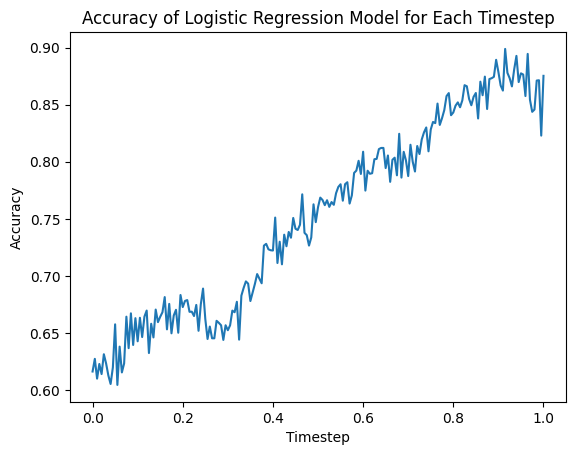

In [48]:
# Test accuracy of model for each timestep on test data and plot
accuracies = []
timesteps = []

for timestep, i in zip(models, test_data.keys()):
    # model = models[timestep]
    # Convert test data to array
    y_test = np.array([row["label"] for row in test_data[i]])
    X_test = np.array([row["rows"].reshape(-1) for row in test_data[i]])
    # Evaluate model using the pipeline (preprocessing + logistic regression)
    accuracy = model.score(X_test, y_test)
    print(f"Timestep {timestep:.2%}: Accuracy = {accuracy:.4f}")
    accuracies.append(accuracy)
    timesteps.append(timestep)

plt.plot(timesteps, accuracies)
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.title("Accuracy of Logistic Regression Model for Each Timestep")
plt.show()

In [26]:
process_data.write_predictions(models, features_test_data, interpolated_dir, "cat_boost_phat_b")

NameError: name 'features_test_data' is not defined